# Photonic waveguide bend
We compute wavelength dependent S-parameters for a photonic waveguide bend in SOI

## Geometry

running luminescent python frontend


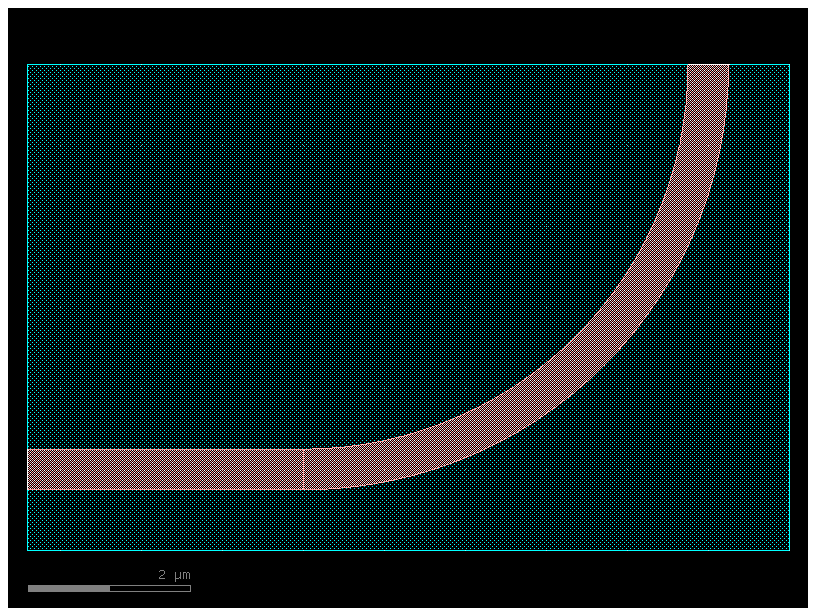

In [2]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import numpy as np
import os
import matplotlib.pyplot as plt

# simulation folder
path = os.path.join("runs", "bend")
name='photonic waveguide bend'

# length units are arbitrary so long as they're consistent
wavelength = 1.55 # characteristic wavelength in microns
wavelengths = np.linspace(1.5, 1.6, 50)
d = 0.22
w_wg = 0.5

# layers
WG = 1, 0
CLAD = 2, 0

# margins
lateral_port_margin = height_port_margin = 0.6
xmargin = 1.25 * lateral_port_margin
zmargin = 1.25 * height_port_margin
source_port_margin = 2 * (w_wg + 2 * lateral_port_margin)

# make component in gdsfactory. alternatively can import .gds into gdsfactory
c = gf.Component()

dut = c << gf.components.bend_circular(5)
ext = c << gf.components.straight(length=source_port_margin)
ext.connect("o2", dut.ports["o1"])

c << gf.components.bbox(component=c, layer=CLAD, right=xmargin, bottom=xmargin)

c.add_port("o1", port=dut.ports["o1"])
c.add_port("o2", port=dut.ports["o2"])  # thru channel
c.plot()

## Solve

saving mode plots to runs\bend\modes\1
showing modes for first wavelength 
using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\bend
0.036904761904761905
0.036904761904761905


0

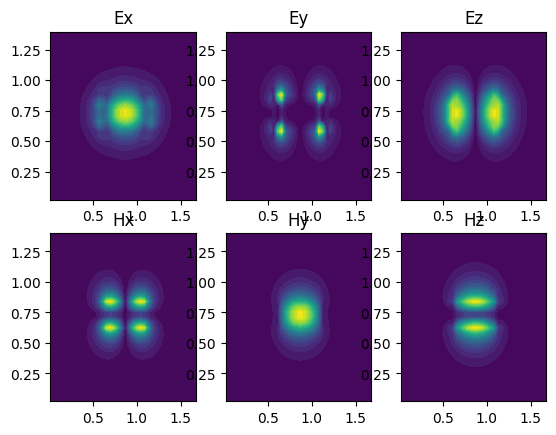

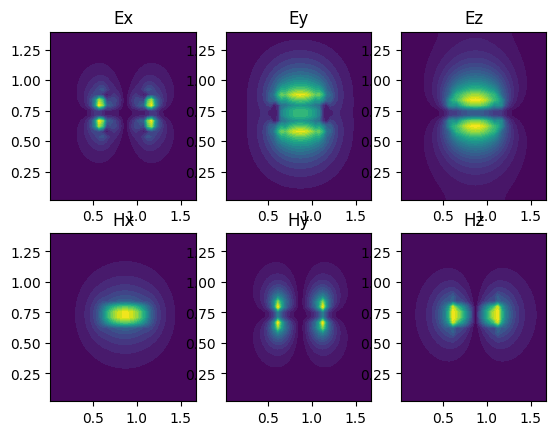

In [3]:
nres = 6  # number of grid points per wavelength in material (not vacuum)

lx = w_wg + 2 * lateral_port_margin
ly = d + 2 * height_port_margin
modes = [
    lumi.Mode(
        ports=["o1", "o2"],
        wavelengths=lumi.chebyshev_nodes(wavelengths[0], wavelengths[-1]),
        start=[-lx / 2, -height_port_margin],  # local xy frame, local y=0 at global zmin of port layer
        stop=[lx / 2, d + height_port_margin],
    )
]

materials_library = {
    "Si": lumi.Material(
        epsilon=12.25,
        # sigma=0.001,
        # chi2=0.001,
        # chi3=0.001,
        # dispersion=[(0.001, 0.001, True)],
    ),
    "SiO2": lumi.Material(epsilon=2.25),
}
materials_library["background"] = materials_library["SiO2"]  # set background material

layer_stack = LayerStack(
    layers={
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=d,
            zmin=0.0,
            material="Si",
            mesh_order=1,
        ),
    }
)

sources = [
    lumi.Source(
        "o1",
        wavelength=wavelength,
        source_port_margin=source_port_margin,
        bandwidth=0.2,
    )
]

lumi.make(
    path=path,  
    name=name,
    component=c,
    modes=modes,
    wavelengths=wavelengths,
    sources=sources,  # launch into port "1"
    #
    zmin=-zmargin,
    zmax=d + zmargin,
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    #
    gpu="CUDA",  # use GPU acceleration
    nres=nres,
    field_decay_threshold=0.0001,  # field decay threshold for stopping simulation
    relative_pml_depths=[1, 1, 0.3],  # relative PML thes in x, y, z
    relative_courant=0.9,
    saveat=20,
    views=[lumi.View("Hz")],
)
0

In [4]:
lumi.solve(path)

loading problem from C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\bend

can't find fdtd binary 


## Visualize


failed plotting new frames


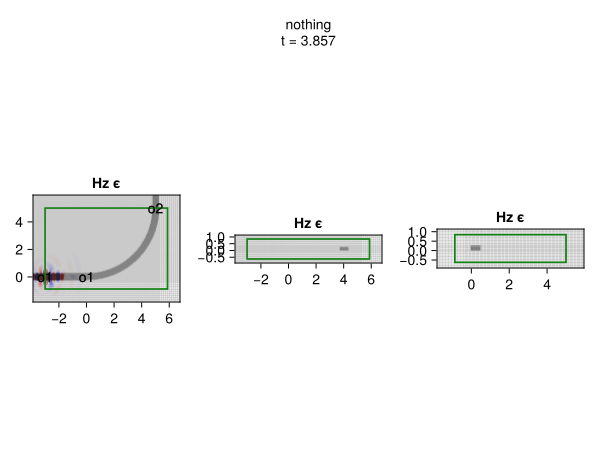

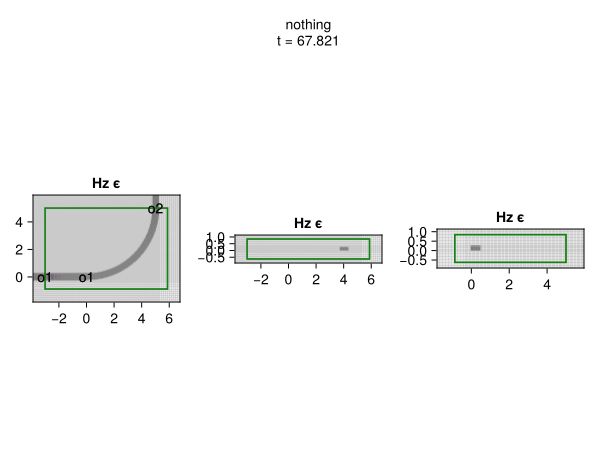

In [5]:
lumi.peek(path)


failed plotting new frames
Video generated successfully at C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\bend\simulation.gif!


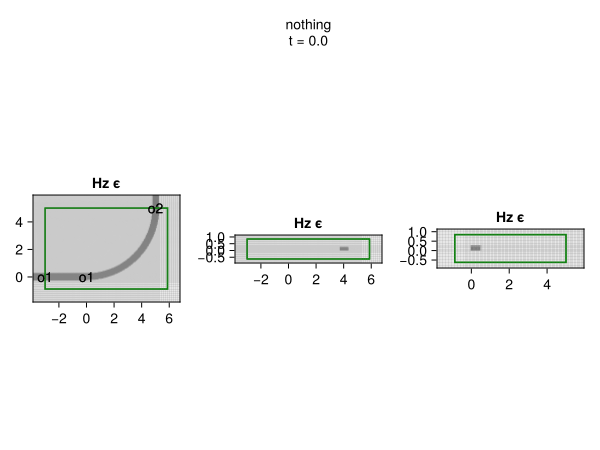

In [6]:
lumi.movie(path)

## Results

loading solution from C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\bend


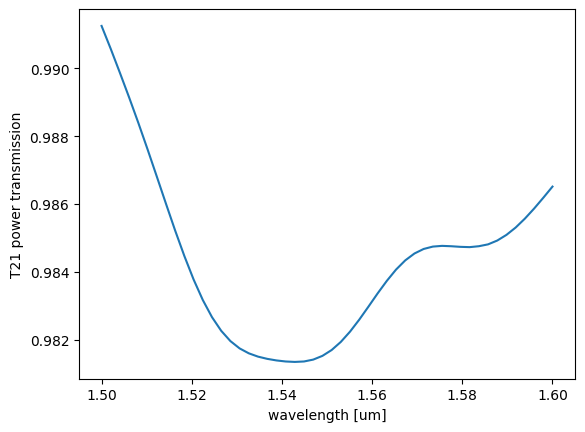

In [7]:
plt.close()
sol = lumi.load(path)
x = wavelengths

y = lumi.query(sol, "To2@0,o1@0")  # wavelength or frequency ordered depending on problem setup
# y = lumi.query(sol, "T2,1")
# y=np.abs2(sol['waves']['o3@0']/sol['waves']['o1@0'])

# y=[10*np.log10(y) for y in y]

plt.plot(x, y)
plt.xlabel("wavelength [um]")
plt.ylabel("T21 power transmission")
plt.show()